# Оптимальная аппроксимация сплайнами
### Матвей Морозов

# Постановка задачи
1) Дана выборка точек $\{x_i \in \mathbb{R}^d, y_i \in \mathbb{R}^1 \}_{i=1}^{n}$

2) $y_i= f_0(x_i) + \xi_i$, где $\xi_i$ - гауссовский шум


## Необходимо:
Построить функцию $\hat{f}: \mathbb{R}^d \rightarrow \mathbb{R}^1$, которая хорошо приближает данные обучающей выборки

# В ходе решения задачи:
1) Были найдены коэффициенты разложения по конечномерному базису для приближающей функции;

2) Был реализован алгоритм нахождения сглаживающего сплайна;

3) Был придуман и реализован алгоритм нахождения коэффициентов разложения за указанное время;

$$\{x_i \in \mathbb{R}, y_i \in \mathbb{R}^1 \}_{i=1}^{n}$$
$$\hat{f}: \mathbb{R}^d \rightarrow \mathbb{R}^1$$




Подобная задача сводится к поиску коэффициентов разложения по конечномерному базису $\{\psi_j\}_{j=1}^{n}$
        $$f(x) = \sum_{i=1}^{n} \alpha_i \psi_i$$

# Сглаживающие сплайны
$$\hat{f} = argmin_{\alpha} (\sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \int (\cfrac{d^2f}{dx^2})^2)$$

Подобная задача сводится к поиску коэффициентов разложения по конечномерному базису $\{\psi_j\}_{j=1}^{n}$

Необходимо решить задачу квадратичной оптимизации

$$\hat{f} = argmin_{\alpha} (\sum_{i=1}^{n} (y_i - \alpha^{T}\psi_i)^2 + \lambda \alpha^{T} \Omega \alpha)$$



1) матрицы $\psi$ - это $n \times p$ матрица значений базисных функций в точках выборки, $\psi|_{i,j} = \psi_j(x_i)$,

2)  $p$ - число этих базисных функций,

3) $\psi_i$ - одна строк матрицы $\psi$,

4) $\Omega$ - симметричная положительно определённая $p \times p$ матрица, состоящая из скалярных произведений вторых производных базисных функций.

In [195]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Определим функцию B-сплайна

$$B_{i,0} (x) := \begin{cases}
1 \ \ if \ \ t_i < x < t_{i+1} \\
0 \ \ otherwise
\end{cases}
$$
        
$$B_{i,k} (x) := \cfrac{x - t_i}{t_{i+k} - t_i} B_{i,k-1}(x) + \cfrac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}}B_{i,k+1}(x)
    $$

In [196]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2


## Пример системы линейных базисных сплайнов

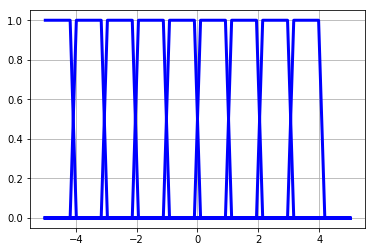

In [197]:
k = 0
t = [-7,-6,-5,-4,-3,-2,-1 ,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

xx = np.linspace(-5, 5, 50)

fig, ax = plt.subplots()

for i in range (11):
    ax.plot(xx, [B(x, k, i ,t) for x in xx], 'blue', lw=3)
    
ax.grid(True)  
plt.show()

## Пример системы кубических B-сплайнов

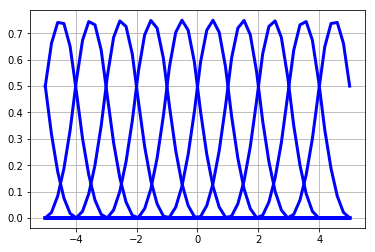

In [198]:
k = 2
fig, ax = plt.subplots()

for i in range (11):
    ax.plot(xx, [B(x, k, i ,t) for x in xx], 'blue', lw=3)

ax.grid(True) 
plt.show()

# Коэффициенты разложения по B-spline

$$\hat{f} = argmin_{\alpha} (\sum_{i=1}^{n} (y_i - \alpha^{T}\psi_i)^2 + \lambda \alpha^{T} \Omega \alpha)$$

Как будет показано дальше, что коэффициенты разложения будут иметь вид:
$\alpha_{\lambda} = (\psi^{T} \psi + \lambda \Omega)^{-1} \psi^{T} y$

In [199]:
from scipy.misc import derivative #импортировали библиотеку для нахождения производной функции в точке

### Определим функцию, которая считает коэффициенты разложения по B-сплайнам
$$f(x) = \sum_{i=1}^{n} \alpha_i B_i$$

### Также определим функцию, которая находит искомый сглаживающий сплайн

In [200]:
# m - число точек выборки
# p - число базисных функций (B-сплайнов), которыми мы будем искать приближение
# m - степень полинома B-сплайна
# lam - параметр сглаживания

#функция, вычисляющая коэффициенты
def spline (n, p, m, lam):
    M = [0] * n 
    for i in range(n): 
        M[i] = [0] * p


    #задали матрицу базисных функций
    for i in range (n):
        for k in range (p):
            M[i][k] = B(x[i],m,k, t)

    G = [0] * n 
    for i in range(n): 
        G[i] = [0] * p

    for i in range (n):
        for k in range (p):
            def j(x):
                return B(x,m,k,t)
            G[i][k] = derivative (j,x[i],dx=1e-6,n=2)

    H = np.transpose(G)

    C = [0] * p
    for i in range(p): 
        C[i] = [0] * p

    #вычислили матрицу вторых производных
    for i in range (p):
        for k in range (p):
            C[i][k]= np.dot(H[i],H[k])
   
    #посчитали вектор коэффициентов, с которыми мы будем брать B-сплайны
    S = np.dot (np.dot (np.linalg.inv(np.dot(np.transpose (M),M) + np.dot (lam, C)), np.transpose (M)), y)
    return S

#искомая функция
def f(x):
    l = 0
    for i in range (p):
        l = l + S[i]* B(x, m, i, t)
    return l

### Построим как пример $sin(x)$

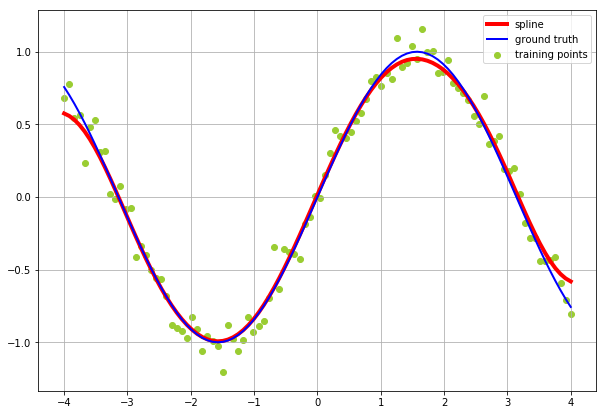

In [235]:
n=100
p = 9
m= 5
lam = 0.025

xx = np.linspace(-4, 4, 100)
x = np.linspace(-4, 4, 100)

#настоящая функция
def g(x):
    return np.sin(x)

#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.1

S = spline (n, p, m, lam)
fig, ax = plt.subplots(figsize=[10, 7])

plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=4, label = 'spline')


ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
    
ax.grid(True)
plt.legend(loc='best')

# Коэффициент сглаживания

Посмотрим, как будет вести себя сплайн-функция в зависимости о коэффициента сглаживания $\lambda$.

### Функция $\arctan (x)$
### Хорошо подобранный коэффициент сглаживания

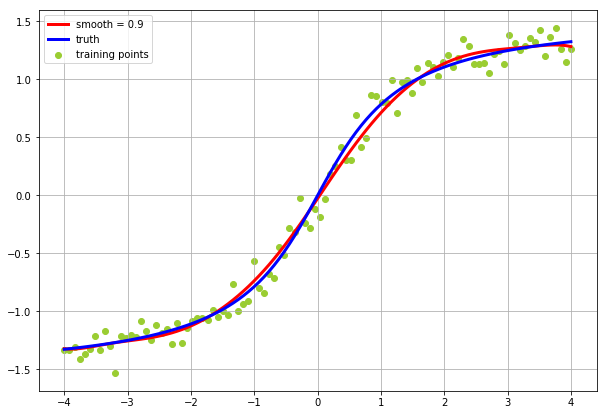

In [194]:
#настоящая функция
def g(x):
    return np.arctan(x)

xx = np.linspace(-4, 4, 100)
x = np.linspace(-4, 4, 100)

n=100
p = 10
m= 4
lam = 0.09


#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.1

fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 0.9')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.legend(loc='best')
ax.grid(True)


### $\lambda = 0$
### Отсутствие сглаживаня. Сглаживающий сплайн превращается в интерполяционный сплайн

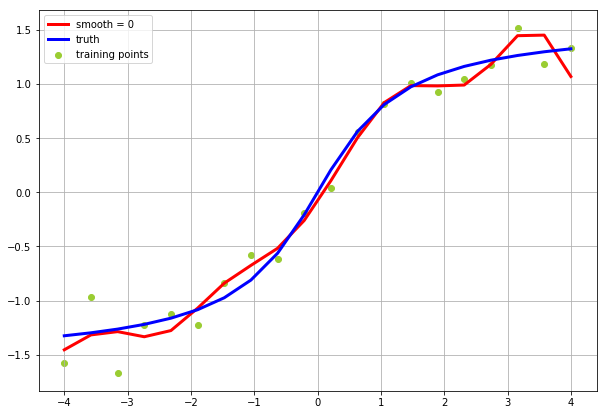

In [206]:
def g(x):
    return np.arctan(x)
xx = np.linspace(-4, 4, 20)
x = np.linspace(-4, 4, 20)
n=20
p = 9
m= 4
lam = 0
y = g(x) + np.random.normal(0,1,20)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 0')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.legend(loc='best')
ax.grid(True)

### Бесконечное сглаживание ($\lambda = \infty$). Сплайн превращается в МНК аппкроксимацию

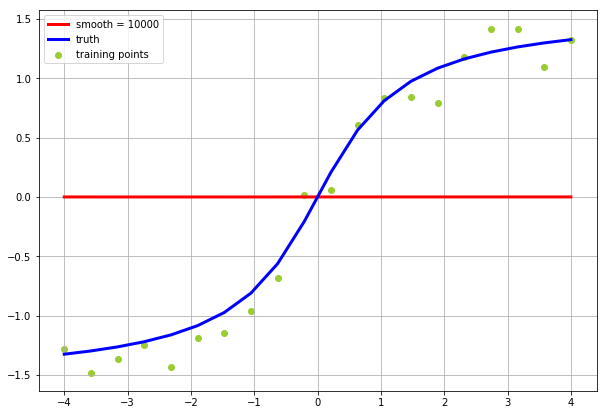

In [207]:
xx = np.linspace(-4, 4, 20)
x = np.linspace(-4, 4, 20)
n=20
p = 9
m= 4
lam = 100000
y = g(x) + np.random.normal(0,1,20)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 10000')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.legend(loc='best')
ax.grid(True)

# Примеры построения сплайн-функций

## $x \cdot \sin(x)$

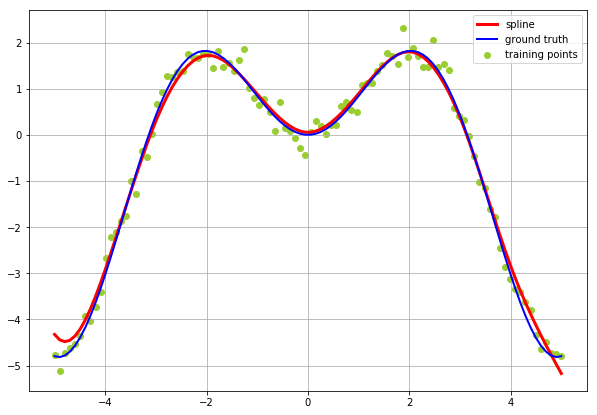

In [216]:
#настоящая функция
def g(x):
    return x*np.sin(x)

xx = np.linspace(-5, 5, 100)
x = np.linspace(-5, 5, 100)
n=100
p =12
m= 3
lam = 0.025
#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
S = spline (n, p, m, lam)
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
ax.grid(True)
plt.legend(loc='best')

## $\exp (-x^2) \cdot \sin(x)$

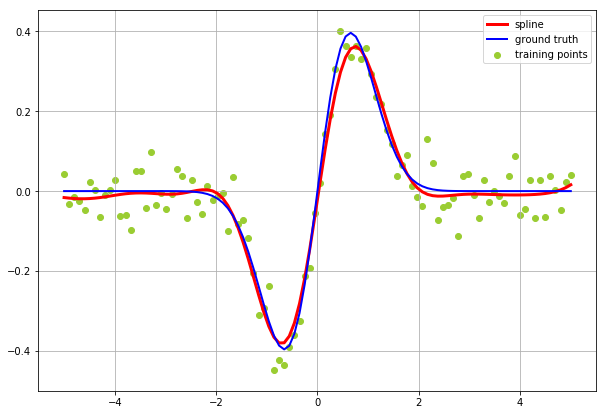

In [234]:
#настоящая функция
def g(x):
    return np.exp(-x**2)*np.sin(x)

xx = np.linspace(-5, 5, 100)
x = np.linspace(-5, 5, 100)
n=100
p =12
m= 4
lam = 0.0025
#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.05
fig, ax = plt.subplots(figsize=[10, 7])
S = spline (n, p, m, lam)
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
ax.grid(True)
plt.legend(loc='best')

# Необходимо: 
## доказать корректность формулы

$$\alpha_{\lambda} = (\psi^{T} \psi + \lambda \Omega)^{-1} \psi^{T} y$$
и предложить алгоритм вычисления коэффициентов разложения $\alpha_{\lambda}$ для набора значений $\lambda$, который на этапе инициализации требует $O(np^2 + p^3)$ операций, а затем для каждого параметра регуляризации $\lambda$ всего $O(p^2)$ операций.

### Побробуем реализовать разобранный мой алгоритм и увидеть ускорение по времени

In [457]:
def myspline(n, p, m):
    #задали матрицу базисных функций
    for i in range (n):
        for k in range (p):
            M[i][k] = B(x[i],m,k, t)

    G = [0] * n 
    for i in range(n): 
        G[i] = [0] * p

    for i in range (n):
        for k in range (p):
            def j(x):
                return B(x,m,k,t)
            G[i][k] = derivative (j,x[i],dx=1e-6,n=2)

    H = np.transpose(G)

    C = [0] * p
    for i in range(p): 
        C[i] = [0] * p

    #вычислили матрицу вторых производных
    for i in range (p):
        for k in range (p):
            C[i][k]= np.dot(H[i],H[k])

    u, s, vh = np.linalg.svd(C, full_matrices=True)
    u2, f, vh2 = np.linalg.svd(np.dot(np.transpose (M),M), full_matrices=True)

    u1 = np.linalg.inv(u)
    vh1 = np.linalg.inv(vh)

    V = np.dot(np.dot (vh1,np.transpose (vh1)), np.dot(np.transpose (M), np.transpose(y)))
    
    return [V,s,f]

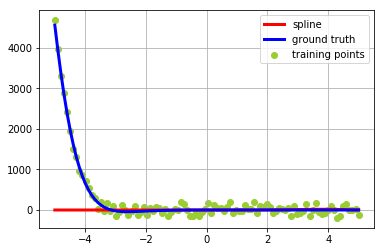

In [461]:
import numpy as np

xx = np.linspace(-5, 5, 100)
x = np.linspace(-5, 5, 100)

#настоящая функция
def g(x):
    return np.exp(-x)*np.sin(x)/(2**x)

#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*100

n=100
p=10
m=3
lam = 1000


V = myspline(n, p, m)[0]
s = myspline(n,p,m)[1]
f = myspline(n,p,m)[2]

Z = [0] * p 
for i in range(p): 
     Z[i] = [0] * p
        
for k in range(p): 
     Z[k][p-1-k] = (f[k]*lam + s[k])**(-1)

    
S = np.dot (Z,V)

def f(x):
    l = 0
    for i in range (p):
        l = l + S[i]* B(x, m, i, t)
    return l


fig, ax = plt.subplots()
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')


ax.plot (xx, [g(x) for x in xx], 'blue', lw=3, label = "ground truth")
    
ax.grid(True)
plt.legend(loc='best')

plt.savefig('1.png', format='png', dpi=1000)